In [165]:
WORKSPACE_PATH = 'workspace'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'

In [166]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [244]:
import json

def json_read(data_path):
    with open(data_path, 'r') as data:
        data = json.load(data)
    return data

In [245]:
JSON_NAME = '/instances_default.json'
DATA_PATH = ANNOTATION_PATH+'/original'+ JSON_NAME
data = json_read(DATA_PATH)

Bennene Bilder im Verzeichnis images und in der Annotationsdatei um

In [246]:
import os

def rename_images(IMAGE_PATH):
    index=1
    img  = os.listdir(IMAGE_PATH)
    for i in img:
        new_name = f"{index:012d}"+'.jpeg'
        old_path = os.path.join(IMAGE_PATH, i)
        new_path = os.path.join(IMAGE_PATH, new_name)
        os.rename(old_path, new_path)
        index += 1

def rename_images_in_annotation():
    index=1
    for img in data['images']:
        new_name = f"{index:012d}"+'.jpeg'
        img['file_name'] = new_name 
        index += 1

rename_images(IMAGE_PATH+'/original')
rename_images_in_annotation()

with open(ANNOTATION_PATH+'/original' + JSON_NAME, 'w') as destination_file:
    json.dump(data, destination_file, indent=2)  

In [247]:
images = []
bounding_boxes = []
labels = []
image_height = 1920
image_width = 1080

for image in data['images']:
    one_image = []
    one_image.append(image['id'])
    one_image.append(image['file_name'])
    images.append(one_image)

for annotation in data['annotations']:
    one_box = []
    box_and_id = []
    one_box.append(annotation['bbox'])
    bounding_boxes.append(one_box)

In [248]:
def resize_imgaes(input_path, output_path, height, width):
    image =  cv2.imread(input_path)
    resized_image = cv2.resize(image, (height, width))
    cv2.imwrite(output_path, resized_image)    

def resize_bounding_boxes_and_area(input_path,bounding_boxes, height, width):
    image =  cv2.imread(input_path)
    height_ratio = height / image.shape[0]
    width_ratio = width / image.shape[1]
    
    for box in bounding_boxes:
        resized_boxes = []
        resized_area = 0

        x = np.round(box[0]*width_ratio,2)
        y = np.round(box[1]*height_ratio,2)
        x_width = np.round(box[2]*width_ratio,2)
        y_height = np.round(box[3]*height_ratio,2)
        resized_boxes.append([x, y, x_width, y_height])

        resized_area = x_width * y_height

    return x, y, x_width, y_height, resized_area


In [249]:
import os

new_height = 224
new_width = 224
OUTPUT_PATH_IMAGES = IMAGE_PATH + '/' + str(new_height) + 'x' + str(new_width)
OUTPUTPATH_ANNOTATIONS = ANNOTATION_PATH + '/' + str(new_height) + 'x' + str(new_width)

os.makedirs(OUTPUT_PATH_IMAGES, exist_ok=True)
os.makedirs(OUTPUTPATH_ANNOTATIONS, exist_ok=True)

#Copy JSON Doc in new ANNOTATIONPATH
with open(DATA_PATH, 'r') as source_file:
    data = json.load(source_file)
with open(OUTPUTPATH_ANNOTATIONS + JSON_NAME, 'w') as destination_file:
    json.dump(data, destination_file, indent=2)    


In [250]:
#Resize Images
for img in range(len(images)):
    resize_imgaes(IMAGE_PATH+'/original'+ '/' +images[img][1], OUTPUT_PATH_IMAGES+ '/' +images[img][1], new_height, new_width)


with open(OUTPUTPATH_ANNOTATIONS + JSON_NAME, 'r') as json_data:
    data = json.load(json_data)


#Resize BBox and area
for i, annotation in enumerate(data['annotations']):
    calculate_resize = resize_bounding_boxes_and_area(IMAGE_PATH+'/original'+ '/' +images[0][1],bounding_boxes[i], new_height, new_width)
    new_box = calculate_resize[0],calculate_resize[1],calculate_resize[2],calculate_resize[3]
    new_area = calculate_resize[4]
    annotation['bbox'] = new_box
    annotation['area'] = new_area

#Change height/width
for image in data['images']:
    image['height']=new_height
    image['width']=new_width

with open(OUTPUTPATH_ANNOTATIONS + JSON_NAME, 'w') as destination_file:
    json.dump(data, destination_file, indent=2)    

Create Dataset

In [251]:
import json

images = data['images']
annotations = data['annotations']
categories = data['categories']

dataset = []

for annotation in annotations:
    image_info = next(image for image in images if image['id'] == annotation['image_id'])
    image_path = OUTPUT_PATH_IMAGES + '/'+ image_info['file_name']
    bbox = annotation['bbox']  # [x, y, width, height]
    class_id = annotation['category_id']

    xmin, ymin, width, height = bbox
    xmax, ymax = xmin + width, ymin + height

    dataset.append({
        'image_path': image_path,
        'bbox': [xmin, ymin, xmax, ymax],
        'class_id': class_id
    })

print(len(dataset))
da =dataset[0]
print(dataset[0])
print(da['image_path'])


697
{'image_path': 'workspace/images/224x224/000000000001.jpeg', 'bbox': [11.48, 60.11, 151.89, 110.05], 'class_id': 1}
workspace/images/224x224/000000000001.jpeg


In [252]:
import os

def get_file_list(directory):
    file_list = []
    for filename in os.listdir(directory):
        full_path = os.path.join(directory, filename)
        normalized_path = os.path.normpath(full_path)
        normalized_path = normalized_path.replace(os.path.sep, '/')
        if os.path.isfile(normalized_path):
            file_list.append(normalized_path)
    return file_list

In [271]:
directory_path = OUTPUT_PATH_IMAGES
files = get_file_list(directory_path)


bbox_list=[]
class_id_list=[]
image_path_list=[]

for k in files:
    ann_bbox=[]
    ann_class_id=[]
    for i in dataset:
        d = i
        if d['image_path'] == k:
            ann_bbox.append(d['bbox'])
            ann_class_id.append(d['class_id'])
    
    image = cv2.imread(d['image_path'])
    image = image / 255.0 

        
    bbox_list.append(ann_bbox)
    class_id_list.append(ann_class_id)
    image_path_list.append(image)

images_data = np.array(image_path_list)
bounding_boxes = np.array(bbox_list)
class_labels = np.array(class_id_list)

print(images_data.shape)
print(bounding_boxes.shape)
print(class_labels.shape)
class_labels = np.array(class_labels)[:, np.newaxis]
print(class_labels.shape)


(17, 224, 224, 3)
(17, 41, 4)
(17, 41)
(17, 1, 41)


In [256]:
base_model = keras_cv.models.MobileNetV3Backbone.from_preset(
    "mobilenet_v3_large_imagenet",
    load_weights=False,
)
#Freeze base model
base_model.trainable = False

New Top Layer

In [273]:
import keras

inputs = keras.Input(shape=(new_height, new_width, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

class_id_output = keras.layers.Dense(41, activation='softmax', name='class_id')(x)

bbox_output = keras.layers.Dense(41, name='bbox')(x)
model = keras.Model(inputs, [class_id_output, bbox_output])

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss={'class_id': 'sparse_categorical_crossentropy', 'bbox': 'mean_squared_error'},#Regression für bbox
    metrics={'class_id': 'accuracy'}
)

model.fit(images_data, {'class_id': class_labels, 'bbox': bounding_boxes}, epochs=20, validation_split=0.2)


Epoch 1/20


ValueError: in user code:

    File "c:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "c:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\Tristan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 1706, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 41 and 4 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](model_26/bbox/BiasAdd, IteratorGetNext:1)' with input shapes: [?,41], [?,41,4].


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
img_path = OUTPUT_PATH_IMAGES+'/000000000006.jpeg'  # Replace with the path to your image
img = image.load_img(img_path, target_size=(new_height, new_width))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
predictions = model.predict(img_array)

# Extract class_id and bbox predictions
class_id_predictions, bbox_predictions = predictions

# For example, print the predicted class_id
predicted_class_id = np.argmax(class_id_predictions, axis=1)
print("Predicted Class ID:", predicted_class_id[0])

# For bbox, you may want to further post-process the predictions based on your task
print("Predicted Bbox:", bbox_predictions[0])

1/1 [==============================] - 1s 1s/step
Predicted Class ID: 39
Predicted Bbox: [0.35693628 0.35946482 0.35886663 0.35946742]


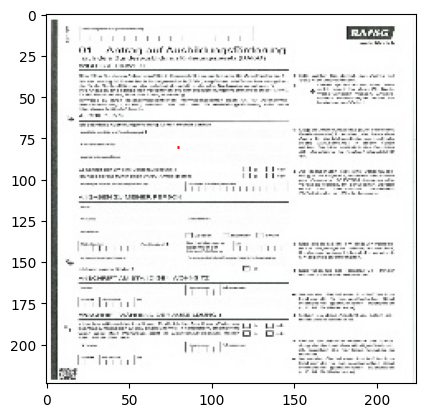

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Load the original image for visualization
original_img = Image.open(img_path)

# Create a figure and axis
fig, ax = plt.subplots(1)

# Display the original image
ax.imshow(original_img)

# Extract the predicted bbox
predicted_bbox = bbox_predictions[0]

# Convert normalized coordinates to actual pixel values
xmin, ymin, xmax, ymax = predicted_bbox
xmin = int(xmin * original_img.width)
xmax = int(xmax * original_img.width)
ymin = int(ymin * original_img.height)
ymax = int(ymax * original_img.height)

# Create a Rectangle patch
rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')

# Add the rectangle to the Axes
ax.add_patch(rect)

# Show the plot
plt.show()
